In [ ]:
import numpy as np
import pandas as pd



# Task:-1

Loading dataset

In [ ]:
y_train = np.array(pd.read_csv(r"C:\Users\HP\Downloads\human+activity+recognition+using+smartphones (1)\UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt", header=None)).reshape(-1)

print(y_train.shape)
acc_x = pd.read_csv(r"C:\Users\HP\Downloads\human+activity+recognition+using+smartphones (1)\UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\body_acc_x_train.txt", header=None, delim_whitespace=True)
acc_y = pd.read_csv(r"C:\Users\HP\Downloads\human+activity+recognition+using+smartphones (1)\UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\body_acc_y_train.txt", header=None, delim_whitespace=True)
acc_z = pd.read_csv(r"C:\Users\HP\Downloads\human+activity+recognition+using+smartphones (1)\UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\body_acc_z_train.txt", header=None, delim_whitespace=True)
print(acc_x.shape, acc_y.shape, acc_z.shape)

(7352,)


C:\Users\HP\AppData\Local\Temp\ipykernel_18288\4177669160.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  acc_x = pd.read_csv(r"C:\Users\HP\Downloads\human+activity+recognition+using+smartphones (1)\UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\body_acc_x_train.txt", header=None, delim_whitespace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_18288\4177669160.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  acc_y = pd.read_csv(r"C:\Users\HP\Downloads\human+activity+recognition+using+smartphones (1)\UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\body_acc_y_train.txt", header=None, delim_whitespace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_18288\4177669160.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future

(7352, 128) (7352, 128) (7352, 128)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtaidistance import dtw
from scipy.linalg import eigh
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score

segmenting the data to overlapping timeseries

In [ ]:
X_train=np.stack([acc_x, acc_y,acc_z], axis=-1)
print("size of original data", X_train.shape)

size of original data (7352, 128, 3)


In [ ]:
window=10
step=6
samples, timestamp, features=X_train.shape
time_segments=[]
for i in range(samples):
    for j in range(0,timestamp-window+1,step):
        s=X_train[i,j:j+window,:]
        time_segments.append(s)

segments=np.array(time_segments)
print("size of segmented data", segments.shape)

size of segmented data (147040, 10, 3)


computing pairwise distance in whole data will be very expensive, so we will use data of size 500.

In [ ]:
data=segments[10:200]
n=data.shape[0]
print(n)

190


computing pairwise distance and eucledean distance

In [ ]:
dtw_distance=np.zeros((n,n))
eucl_distance=np.zeros((n,n))
for i in range(n):
    for j in range(n):
        s1=data[i].flatten()
        s2=data[j].flatten()
        dtw_distance[i, j], _ = fastdtw(s1, s2)
        eucl_distance[i,j]=euclidean(s1, s2)




we are taking sigma=1.0, for similarity matrix

In [ ]:
sigma=1
W_dtw=np.exp(-(dtw_distance ** 2) / (2 * sigma ** 2))
W_euclidean=np.exp(-(eucl_distance ** 2) / (2 * sigma ** 2))

print("size of similarity matrix of dtw distance: ", W_dtw.shape)
print("size of similarity matrix of euclidean distance: ", W_euclidean.shape)

size of similarity matrix of dtw distance:  (190, 190)
size of similarity matrix of euclidean distance:  (190, 190)


# Task:-2

In [ ]:
median_dist=np.median(dtw_distance ** 2)
K=np.exp(-dtw_distance ** 2 / median_dist)

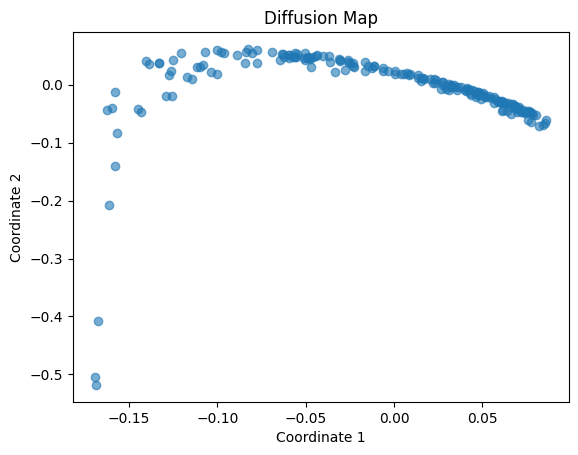

In [ ]:
row_sums = []
for row in K:
    row_sums.append(sum(row))
row_sums=np.array(row_sums)
D_inv=np.diag(1/row_sums)
D_inv_sqrt=np.sqrt(D_inv)
L=np.eye(n)-D_inv_sqrt@K@D_inv_sqrt

e_values,e_vectors=eigh(L)
sorted_idx=np.argsort(e_values)
e_values=e_values[sorted_idx]
e_vectors=e_vectors[:, sorted_idx]

embedding_2d=e_vectors[:,1:3]
x=embedding_2d[:,0]
y=embedding_2d[:,1]
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.6)
plt.title("Diffusion Map")
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()


K-means clustering

Performance of Kmeans according to adjusted rand index:  0.08379749483323928
Performance of Kmeans according to Silhuulette score:  0.5301210369881694


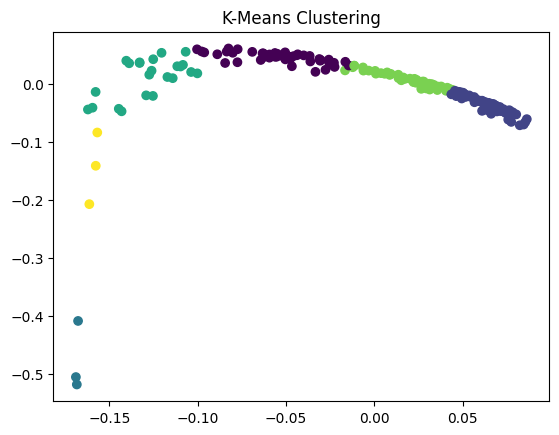

In [ ]:
Labels=y_train[10:200] #because we took data=segments[10:200] previously

kmeans=KMeans(n_clusters=6,random_state=42).fit(embedding_2d)
k_labels=kmeans.labels_

x=embedding_2d[:,0]
y=embedding_2d[:,1]
plt.scatter(x,y,c=k_labels, cmap='viridis')
plt.title("K-Means Clustering")

k_ari=adjusted_rand_score(Labels,k_labels)
k_sil=silhouette_score(embedding_2d,k_labels)

print("Performance of Kmeans according to adjusted rand index: ", k_ari)
print("Performance of Kmeans according to Silhuulette score: ", k_sil)


Performance of DBSCAN according to adjusted rand index:  0.0
Performance of DBSCAN according to Silhuulette score:  -1


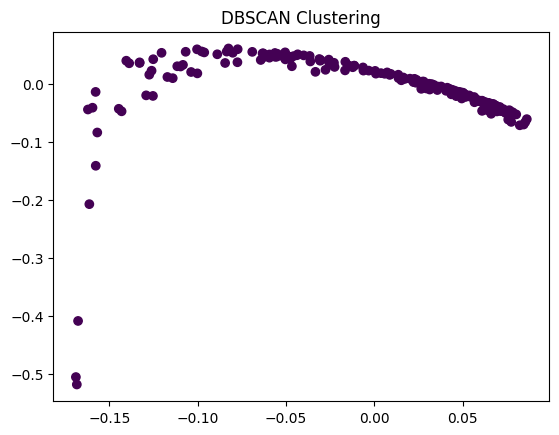

In [ ]:
dbscan=DBSCAN(eps=0.5,min_samples=5).fit(embedding_2d)
d_labels=dbscan.labels_

d_ari=adjusted_rand_score(Labels,d_labels)

if len(np.unique(d_labels))>=2:   ##because these methods need atleast 2 clusters
    d_sil=silhouette_score(embedding_2d,d_labels)
else:
    d_sil=-1


plt.scatter(x,y,c=d_labels, cmap='viridis')
plt.title("DBSCAN Clustering")


print("Performance of DBSCAN according to adjusted rand index: ", d_ari)
print("Performance of DBSCAN according to Silhuulette score: ", d_sil)


# Task:-4

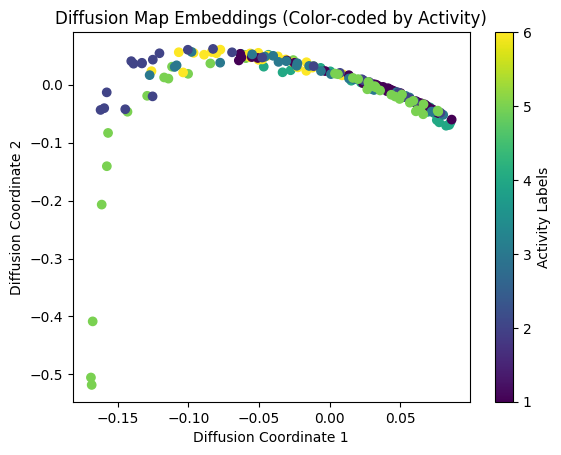

In [ ]:
plt.scatter(x,y,c=Labels,cmap='viridis')
plt.colorbar(label="Activity Labels")
plt.title("Diffusion Map Embeddings (Color-coded by Activity)")
plt.xlabel("Diffusion Coordinate 1")
plt.ylabel("Diffusion Coordinate 2")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

raw_data=data.reshape(n, -1)
X_pca=PCA(n_components=2).fit_transform(raw_data)
X_tsne=TSNE(n_components=2,random_state=42).fit_transform(raw_data)
X_diff=embedding_2d  # Diffusion Map


In [ ]:
def evaluating(data, labels):
    kmeans=KMeans(n_clusters=6, random_state=42).fit(data)
    k_labels=kmeans.labels_
    ari=adjusted_rand_score(labels,k_labels)
    sil=silhouette_score(data,k_labels)
    return ari,sil,k_labels

ari_data,sil_data,k_raw = evaluating(raw_data,Labels)
ari_pca,sil_pca,k_pca = evaluating(X_pca,Labels)
ari_tsne,sil_tsne,k_tsne = evaluating(X_tsne,Labels)
ari_diff,sil_diff,k_diff = evaluating(X_diff,Labels)

print("Performance of raw features on Ari: ",ari_data, ", on Sil", sil_data)
print("Performance of pca on Ari: ",ari_pca, ", on Sil", sil_pca)
print("Performance of tsne features on Ari: ",ari_tsne, ", on Sil", sil_tsne)
print("Performance of diffusion features on Ari: ",ari_diff, ", on Sil", sil_diff)


Performance of raw features on Ari:  0.1192193376625206 , on Sil 0.14902782063355902
Performance of raw features on Ari:  0.1220871328937924 , on Sil 0.3526976098115446
Performance of raw features on Ari:  0.12465830658581924 , on Sil 0.395386
Performance of raw features on Ari:  0.08379749483323928 , on Sil 0.5301210369881694


In [ ]:
def plotting(x,y,Labels):
    plt.scatter(x,y,c=Labels,cmap='viridis')
    plt.colorbar(label="Activity Labels")
    plt.title("Embedding")
    plt.xlabel("Coordinate 1")
    plt.ylabel("Coordinate 2")
    plt.show()



for raw data


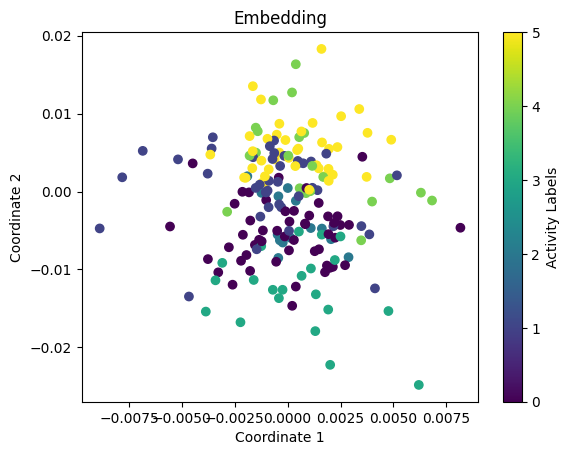

In [ ]:
print("for raw data")
plotting(raw_data[:,0], raw_data[:,1], k_raw)


for PCA


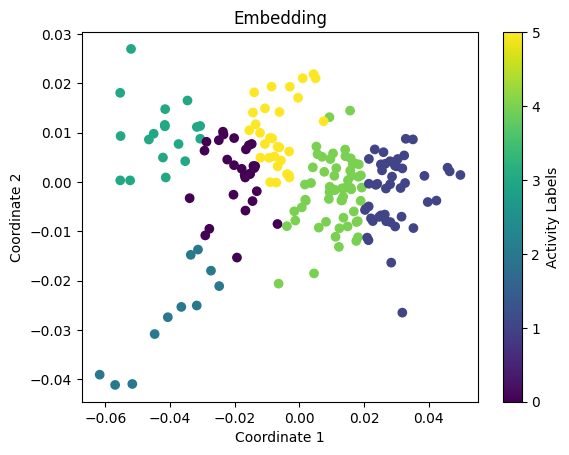

In [ ]:
print("for PCA")
plotting(X_pca[:,0], X_pca[:,1], k_pca)

for tsne


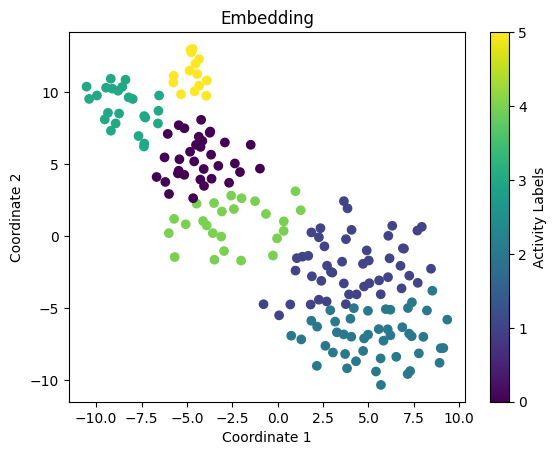

In [ ]:
print("for tsne")
plotting(X_tsne[:,0], X_tsne[:,1], k_tsne)


diffusion map embedding


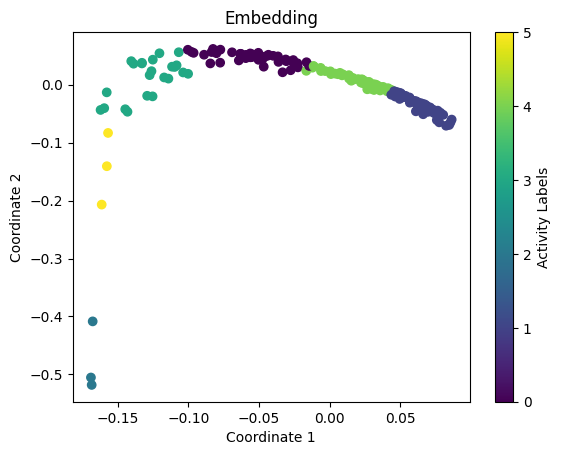

In [ ]:
print("diffusion map embedding")
plotting(X_diff[:,0], X_diff[:,1], k_diff)

# Task:-5

for scale:  0


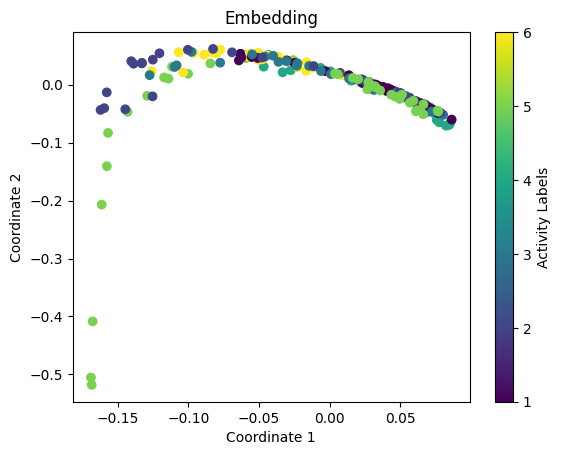

for scale:  1


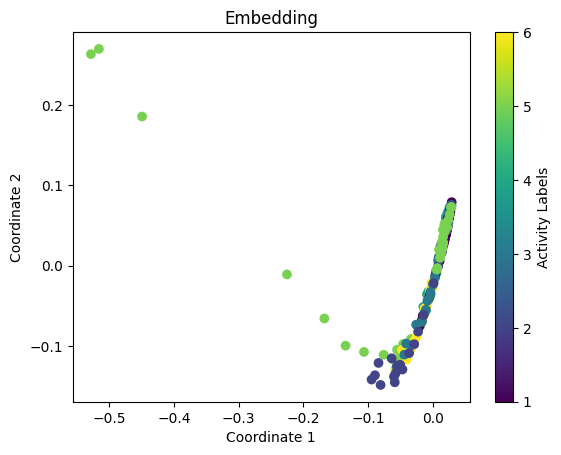

for scale:  2


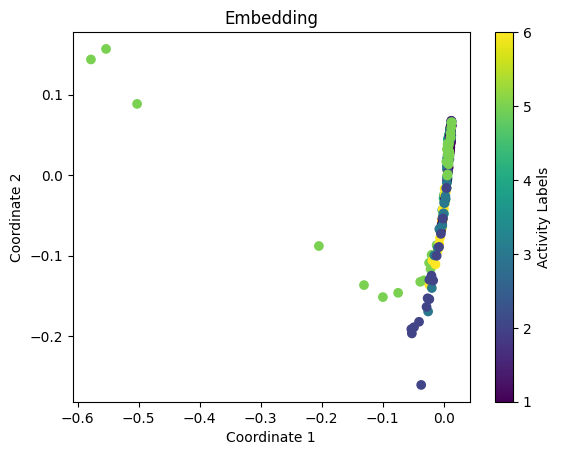

for scale:  3


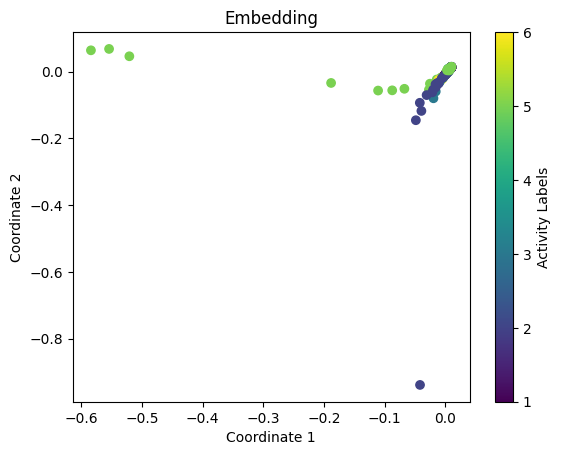

In [ ]:

def multiscale_diffusion_maps(dtw_distance, num_scales):

    n = dtw_distance.shape[0]
    median_dist = np.median(dtw_distance ** 2)

    embeddings = []
    for scale in range(1, num_scales + 1):
        epsilon=median_dist/scale
        K=np.exp(-dtw_distance**2/epsilon)

        row_sums = []
        for row in K:
            row_sums.append(sum(row))
        row_sums=np.array(row_sums)
        D_inv=np.diag(1/row_sums)
        D_inv_sqrt=np.sqrt(D_inv)
        L=np.eye(n)-D_inv_sqrt@K@D_inv_sqrt

        e_values,e_vectors=eigh(L)
        sorted_idx=np.argsort(e_values)
        e_values=e_values[sorted_idx]
        e_vectors=e_vectors[:, sorted_idx]

        embeddings.append(e_vectors[:, 1:3])

    return embeddings

num_scales = 4
diffusion_embeddings = multiscale_diffusion_maps(dtw_distance, num_scales)

for i,j in enumerate(diffusion_embeddings):
    print("for scale: ", i)
    plotting(j[:,0],j[:,1],Labels)



For scale 0
Spectral Clustering performance on ARI: 0.09174304836569844 , on Silhouette: 0.4126326477826669
K-Means performance on ARI: 0.08379749483323928 , on Silhouette: 0.5301210369881694


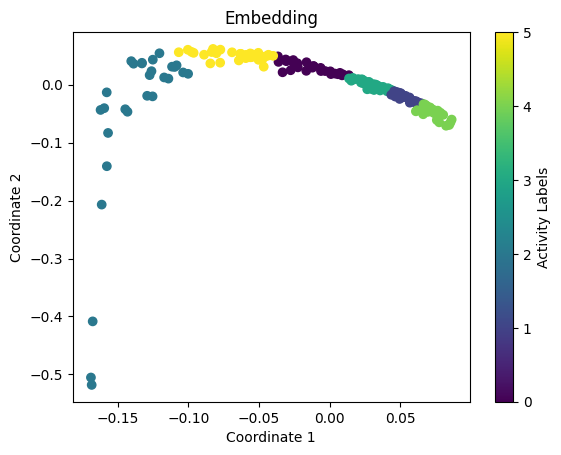



For scale 1
Spectral Clustering performance on ARI: 0.08379547710675904 , on Silhouette: 0.39376516835657127
K-Means performance on ARI: 0.11174631912717983 , on Silhouette: 0.5785387841311875


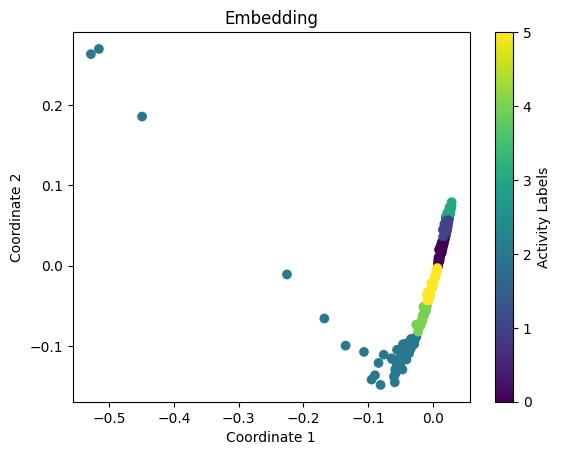



For scale 2
Spectral Clustering performance on ARI: 0.09393220799834383 , on Silhouette: 0.3752234262306611
K-Means performance on ARI: 0.1266881502790213 , on Silhouette: 0.5592891469515235


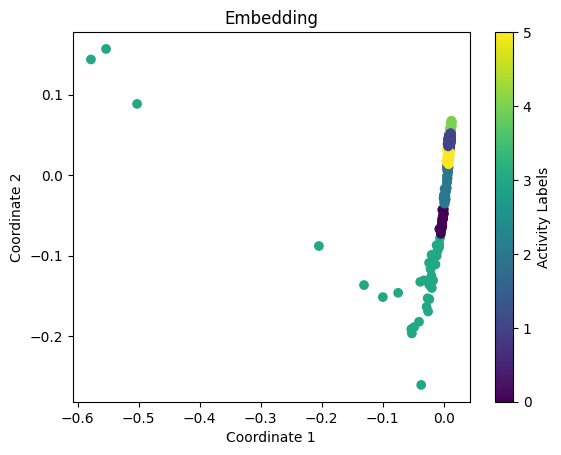



For scale 3
Spectral Clustering performance on ARI: 0.14622959485431833 , on Silhouette: 0.27257122769513464
K-Means performance on ARI: 0.07152207988907852 , on Silhouette: 0.6260273004361531


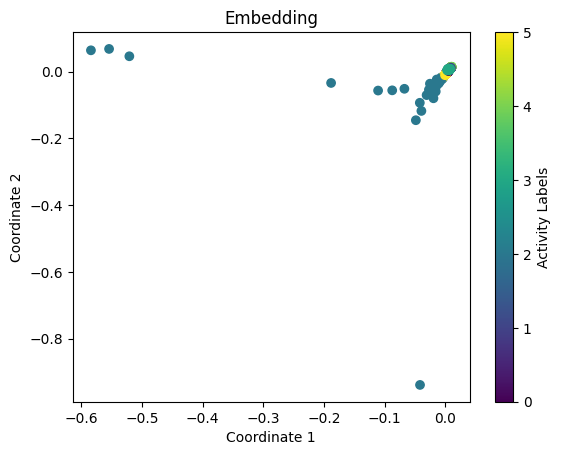

In [ ]:
from sklearn.cluster import SpectralClustering

for i in range(num_scales):
    print("For scale", i)
    X_diffusion=diffusion_embeddings[i]
    n_clusters=6
    spectral=SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    spectral_labels=spectral.fit_predict(X_diffusion)

    kmeans=KMeans(n_clusters=n_clusters, random_state=42).fit(X_diffusion)
    kmeans_labels=kmeans.labels_

    ari_spectral=adjusted_rand_score(Labels,spectral_labels)
    sil_spectral=silhouette_score(X_diffusion,spectral_labels)

    ari_kmeans=adjusted_rand_score(Labels, kmeans_labels)
    sil_kmeans=silhouette_score(X_diffusion, kmeans_labels)

    print("Spectral Clustering performance on ARI:", ari_spectral,", on Silhouette:",sil_spectral)
    print("K-Means performance on ARI:", ari_kmeans,", on Silhouette:",sil_kmeans)

    plotting(X_diffusion[:,0],X_diffusion[:,1],spectral_labels)

    print()
    print()

